In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer 

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


- There are 159,571 comments in our train set for the model to learn from

- let's make a column for total labels marked yes.  that way we can see how many are tagged for multiple levels of toxicity (I'm assuming these are included in this dataset), and how many are not tagged for any type of toxicity

In [4]:
labels = list(train.columns[2:])
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
train[labels].sum(axis=1)

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

In [6]:
train['total'] = train[labels].sum(axis=1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [7]:
train['total'].hist()

In [8]:
train['total'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: total, dtype: int64

In [9]:
143346/159571

0.8983211235124177

In [10]:
159571-143346

16225

89% of the comments were not tagged for any toxicity

In [11]:
train[labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [12]:
train[train['total']>=2]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,4
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,3
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,2


In [13]:
labels_no_toxic = labels.copy()
labels_no_toxic.remove('toxic')

In [14]:
train[(train['toxic']==0) & (train[labels_no_toxic].sum(axis=1)>=1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total
179,006d11791d76b9f3,"REPLY ABOVE:\nThat was me, loser. The UN defin...",0,0,0,0,1,0,1
527,01625cc84c6ef15b,How do you know he is dead. Its just his plan...,0,0,1,0,0,0,1
662,01ccf4d20d31dfbe,Hebrew Name of Lydia \nAppologies to Til Eulen...,0,0,0,0,1,0,1
1232,0350c82d1f207e0e,Bleh. I'm all out of ideas. Is there really so...,0,0,1,0,0,0,1
1351,03aec26f9b6f9ba3,"""\n\n Stop. \n\nStop redirecting the Teddygodz...",0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
158615,f0b46600c7cf2515,"""""""And at least Castro was trying to liberate ...",0,0,1,0,1,0,2
158793,f3d62179cdb93e58,"Hey FayssalFag, will you ever get a life offli...",0,0,1,0,1,0,2
158933,f60a9bd97d717630,Administratore: I need your help to stop DIREK...,0,0,0,0,1,0,1
159103,f896893958bb1cec,"OH DEAR OH DEAR, HOW FUKIN SAD. I WILL REGRET ...",0,0,1,0,0,0,1


In [15]:
train[(train['toxic']==0) & (train['severe_toxic']==1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total


-------------------------------------------------------------------

In [16]:
train['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

What kind of stuff do I want to know about the data?

Is there a max character lenght for these wiki edit comments?



In [17]:
train['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [18]:
len(train['comment_text'][10])

2875

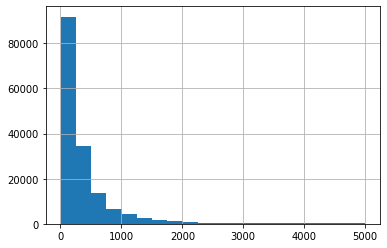

In [19]:
comment_char_length = [len(x) for x in train['comment_text']]
pd.Series(comment_char_length).hist(bins=20)

In [20]:
max(comment_char_length)

5000

In [21]:
min(comment_char_length)

6

In [22]:
pd.Series(comment_char_length).describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
dtype: float64

In [23]:
clean_comments = train[train['total']== 0]
toxic_comments = train[train['total'] > 0]

count    143346.000000
mean        404.347174
std         586.503447
min           6.000000
25%         102.000000
50%         216.000000
75%         452.000000
max        5000.000000
dtype: float64

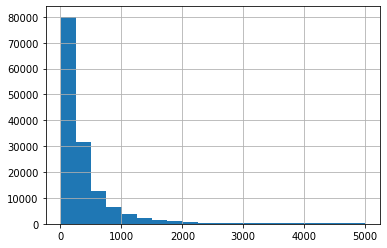

In [24]:
comment_char_length = [len(x) for x in clean_comments['comment_text']]
pd.Series(comment_char_length).hist(bins=20)
pd.Series(comment_char_length).describe()

count    16225.000000
mean       303.304037
std        619.402896
min          8.000000
25%         61.000000
50%        128.000000
75%        283.000000
max       5000.000000
dtype: float64

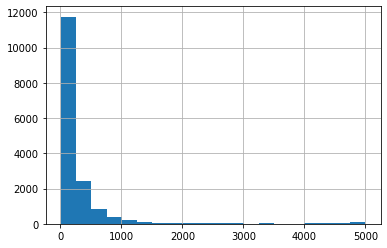

In [25]:
comment_char_length = [len(x) for x in toxic_comments['comment_text']]
pd.Series(comment_char_length).hist(bins=20)
pd.Series(comment_char_length).describe()

In [26]:
def checkIfDuplicates_3(listOfElems):
    ''' Check if given list contains any duplicates '''    
    for elem in listOfElems:
        if listOfElems.count(elem) > 1:
            return True
        return False
    
result = checkIfDuplicates_3(list(train['comment_text']))
 
if result:
    print('Yes, list contains duplicates')
else:
    print('No duplicates found in list')    

No duplicates found in list


In [27]:
all_comments = train['comment_text']

In [28]:
len(list(all_comments))

159571

In [29]:
len(set(list(all_comments)))

159571

In [30]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
total            0
dtype: int64


In [31]:
stopwords_list = stopwords.words('English') + list(string.punctuation) + ["''", '""', '...', '``'] + ["i'm"]
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [32]:

def process_comments(comment):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(comment,pattern)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [33]:
processed_comments = list(map(process_comments, all_comments))

In [34]:
processed_comments[0]

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalisms',
 'closure',
 'gas',
 'voted',
 'new',
 'york',
 'dolls',
 'fac',
 'please',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 'retired']

In [35]:
all_comments[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [36]:
total_vocab = set()
for tokenized_comment in processed_comments:
    total_vocab.update(tokenized_comment)
    
len(total_vocab)

176921

In [37]:
all_comments_together = []
for comment in processed_comments:
    all_comments_together += comment

In [38]:
frq_dist = FreqDist(all_comments_together)
frq_dist.most_common(20)

[('article', 56128),
 ('page', 46343),
 ('wikipedia', 45994),
 ('talk', 37907),
 ('please', 29802),
 ('would', 29252),
 ('one', 28894),
 ('like', 28006),
 ('see', 21597),
 ('also', 20642),
 ('think', 20080),
 ('know', 19121),
 ('edit', 18305),
 ('people', 17932),
 ('articles', 16808),
 ('use', 16708),
 ('time', 15890),
 ('may', 15623),
 ('user', 14356),
 ('thanks', 13911)]

In [39]:
all_toxic = toxic_comments['comment_text']
all_clean = clean_comments['comment_text']

In [40]:
processed_toxic = list(map(process_comments, all_toxic))
processed_clean = list(map(process_comments, all_clean))

In [41]:
total_vocab_toxic = set()
for tokenized_comment in processed_toxic:
    total_vocab_toxic.update(tokenized_comment)
    
len(total_vocab_toxic)

34253

In [42]:
total_vocab_clean = set()
for tokenized_comment in processed_clean:
    total_vocab_clean.update(tokenized_comment)
    
len(total_vocab_clean)

168585

In [43]:
all_comments_together_toxic = []
for comment in processed_toxic:
    all_comments_together_toxic += comment

In [44]:
all_comments_together_clean = []
for comment in processed_clean:
    all_comments_together_clean += comment

In [45]:
frq_dist_toxic = FreqDist(all_comments_together_toxic)
frq_dist_toxic.most_common(50)

[('fuck', 9990),
 ('wikipedia', 3851),
 ('like', 3805),
 ('shit', 3693),
 ('fucking', 3337),
 ('nigger', 3304),
 ('suck', 3249),
 ('ass', 3005),
 ('go', 2965),
 ('u', 2944),
 ('hate', 2656),
 ('get', 2446),
 ('page', 2379),
 ('know', 2366),
 ('gay', 2267),
 ('die', 2141),
 ('faggot', 2027),
 ('people', 2000),
 ('fat', 1982),
 ('moron', 1886),
 ('bitch', 1841),
 ('hi', 1712),
 ('one', 1693),
 ('talk', 1646),
 ('cunt', 1573),
 ('article', 1560),
 ('stop', 1512),
 ('user', 1504),
 ('stupid', 1491),
 ('wiki', 1470),
 ('sucks', 1447),
 ('think', 1395),
 ('jew', 1363),
 ('pig', 1357),
 ('dick', 1337),
 ('want', 1305),
 ('penis', 1244),
 ('time', 1186),
 ('bullshit', 1164),
 ('life', 1156),
 ('would', 1154),
 ('block', 1153),
 ('even', 1140),
 ('right', 1111),
 ('dont', 1078),
 ('asshole', 1069),
 ('make', 1060),
 ('edit', 1058),
 ('please', 1043),
 ('see', 1040)]

In [46]:
frq_dist_clean = FreqDist(all_comments_together_clean)
frq_dist_clean.most_common(50)

[('article', 54568),
 ('page', 43964),
 ('wikipedia', 42143),
 ('talk', 36261),
 ('please', 28759),
 ('would', 28098),
 ('one', 27201),
 ('like', 24201),
 ('see', 20557),
 ('also', 19809),
 ('think', 18685),
 ('edit', 17247),
 ('know', 16755),
 ('articles', 16251),
 ('use', 16195),
 ('people', 15932),
 ('may', 15274),
 ('time', 14704),
 ('thanks', 13468),
 ('user', 12852),
 ('even', 12327),
 ('good', 11956),
 ('make', 11943),
 ('well', 11624),
 ('information', 11599),
 ('could', 11503),
 ('deletion', 11393),
 ('sources', 11116),
 ('get', 10973),
 ('image', 10730),
 ('name', 10712),
 ('wp', 10607),
 ('way', 10514),
 ('first', 10502),
 ('help', 10475),
 ('want', 10305),
 ('new', 10277),
 ('pages', 10252),
 ('source', 10129),
 ('section', 9954),
 ('editing', 9790),
 ('thank', 9711),
 ('need', 9503),
 ('say', 9306),
 ('edits', 9248),
 ('made', 9183),
 ('many', 9076),
 ('used', 8942),
 ('discussion', 8929),
 ('much', 8911)]

In [47]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [48]:
toxic_finder = nltk.collocations.BigramCollocationFinder.from_words(all_comments_together_toxic)

In [49]:
toxic_scored = toxic_finder.score_ngrams(bigram_measures.raw_freq)

In [50]:
toxic_scored[:50]

[(('fuck', 'fuck'), 0.004561061746971903),
 (('nigger', 'nigger'), 0.004294644588854385),
 (('moron', 'hi'), 0.0031437224657867085),
 (('hi', 'moron'), 0.0031373284539918883),
 (('hate', 'hate'), 0.0030243675789500607),
 (('pig', 'pig'), 0.002664171581175177),
 (('jew', 'fat'), 0.0026300701849361345),
 (('fat', 'jew'), 0.0026130194868166133),
 (('go', 'fuck'), 0.0024510378546811627),
 (('shit', 'shit'), 0.0024510378546811627),
 (('ass', 'ass'), 0.0024020170975875394),
 (('bark', 'bark'), 0.0021292059276752013),
 (('wanker', 'wanker'), 0.002052477786137356),
 (('suck', 'suck'), 0.0018777081304122646),
 (('fuck', 'go'), 0.0018414753969082823),
 (('balls', 'balls'), 0.0017754039416951377),
 (('bullshit', 'bullshit'), 0.0017754039416951377),
 (('nipple', 'nipple'), 0.001626210333149328),
 (('faggot', 'faggot'), 0.0016091596350298067),
 (('talk', 'page'), 0.0015707955642608842),
 (('fuck', 'u'), 0.0013960259085357926),
 (('die', 'die'), 0.0013640558495616904),
 (('dickhead', 'dickhead'), 0.

In [53]:
all_toxics_raw = []
for comment in all_toxic:
        pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
        tokens = nltk.regexp_tokenize(comment,pattern)
        lowered = [token.lower() for token in tokens]
        all_toxics_raw += lowered

In [54]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
toxic_finder = nltk.collocations.BigramCollocationFinder.from_words(all_toxics_raw)
toxic_scored = toxic_finder.score_ngrams(bigram_measures.raw_freq)
toxic_scored[:50]

[(('you', 'are'), 0.005246277125373968),
 (('fuck', 'you'), 0.0043560559958363615),
 (('is', 'a'), 0.0041022038768666535),
 (('i', 'am'), 0.003516837118511847),
 (('nigger', 'nigger'), 0.0023356713229404653),
 (('in', 'the'), 0.0023217616177914403),
 (('are', 'a'), 0.0022696002234825962),
 (('you', 'fuck'), 0.0020087932519383756),
 (('i', 'hate'), 0.002002997541459615),
 (('of', 'the'), 0.001955472715533779),
 (('you', 'i'), 0.001929971589427233),
 (('hate', 'you'), 0.0018163756640435281),
 (('moron', 'hi'), 0.0017097345912343357),
 (('hi', 'moron'), 0.0017062571649470793),
 (('if', 'you'), 0.0016598914811169958),
 (('i', 'will'), 0.0015358632768715217),
 (('to', 'be'), 0.0015323858505842656),
 (('pig', 'pig'), 0.0014477684775943628),
 (('jew', 'fat'), 0.0014303813461580815),
 (('fat', 'jew'), 0.0014211082093920648),
 (('i', 'have'), 0.0014129942147218001),
 (('you', 'suck'), 0.0013573553941256997),
 (('shit', 'shit'), 0.0013272176996361454),
 (('go', 'fuck'), 0.001310989710295616),
 (

In [56]:
toxic_pmi_finder = nltk.collocations.BigramCollocationFinder.from_words(all_toxics_raw)
toxic_pmi_finder.apply_freq_filter(1000)
toxic_pmi_scored = toxic_pmi_finder.score_ngrams(bigram_measures.pmi)
toxic_pmi_scored

[(('pig', 'pig'), 9.192658887252072),
 (('moron', 'hi'), 8.622429428542144),
 (('jew', 'fat'), 8.622326721639542),
 (('hi', 'moron'), 8.619492145462594),
 (('fat', 'jew'), 8.612943306180906),
 (('nigger', 'nigger'), 7.3150793170582595),
 (('shit', 'shit'), 6.1784879250549025),
 (('fuck', 'yourself'), 5.511961566930477),
 (('i', 'am'), 5.183123395539191),
 (('go', 'fuck'), 5.041808998358498),
 (('i', 'hate'), 4.64027305765428),
 (('i', 'will'), 4.026722113113983),
 (('to', 'be'), 4.005119726476952),
 (('hate', 'you'), 3.7266027136863187),
 (('you', 'are'), 3.527930119936002),
 (('if', 'you'), 3.432024951586886),
 (('is', 'a'), 3.307774658853411),
 (('in', 'the'), 3.3056941896607377),
 (('you', 'can'), 3.208392726813763),
 (('i', 'have'), 3.2041373655672416),
 (('are', 'a'), 3.1104862352965945),
 (('fuck', 'you'), 3.077333069300945),
 (('you', 'suck'), 3.0155980127323936),
 (('of', 'the'), 2.3099578436733523),
 (('you', 'have'), 2.2595674324967767),
 (('you', 'fuck'), 1.9606396570410602)

In [57]:
toxic_big_string = ' '.join(list(all_toxic))

In [58]:
clean_big_string = ' '.join(list(all_clean))

In [59]:
data = [clean_big_string, toxic_big_string]

In [60]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

In [61]:
first_doc = X[0]
df = pd.DataFrame(first_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(50)

,tfidf
the,0.593095
to,0.350330
of,0.265239
and,0.258550
you,0.222355
is,0.203477
that,0.189755
it,0.174634
in,0.172760
for,0.122003


In [62]:
second_doc = X[1]
df2 = pd.DataFrame(second_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df2 = df2[df2['tfidf']>0]
df2.sort_values(by=["tfidf"],ascending=False).head(50)

,tfidf
you,0.607535
the,0.344030
to,0.262326
and,0.262266
is,0.207090
of,0.189295
fuck,0.149271
your,0.144404
that,0.138761
it,0.136597


In [63]:
X.shape

(2, 189775)

In [64]:
vectorizer = TfidfVectorizer(stop_words=stopwords_list, token_pattern=pattern)
X = vectorizer.fit_transform(data)

In [65]:
first_doc = X[0]
df = pd.DataFrame(first_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
article,0.341506
page,0.275142
wikipedia,0.263721
talk,0.226934
please,0.179984
would,0.175847
one,0.170233
like,0.151458
see,0.128653
also,0.123972


In [66]:
second_doc = X[1]
df2 = pd.DataFrame(second_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df2 = df2[df2['tfidf']>0]
df2.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
fuck,0.503256
wikipedia,0.193885
like,0.191719
shit,0.186076
fucking,0.168138
nigger,0.166475
suck,0.163704
ass,0.151410
go,0.149395
u,0.148185


In [67]:
stopwords_list += ['would', 'one', 'like', 'also', 'know', 'use', 'may']

In [68]:
vectorizer = TfidfVectorizer(stop_words=stopwords_list, token_pattern=pattern, ngram_range=(1,3))
X = vectorizer.fit_transform(data)

In [69]:
first_doc = X[0]
df = pd.DataFrame(first_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
article,0.360218
page,0.290218
wikipedia,0.278171
talk,0.239369
please,0.189846
see,0.135702
think,0.123345
edit,0.113852
articles,0.107277
people,0.105171


In [70]:
second_doc = X[1]
df2 = pd.DataFrame(second_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df2 = df2[df2['tfidf']>0]
df2.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
fuck,0.428407
wikipedia,0.165049
shit,0.158401
fucking,0.143131
nigger,0.141716
suck,0.139357
fuck fuck,0.129067
ass,0.128891
go,0.127175
u,0.126146


In [71]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [72]:
train['char_total'] = [len(x) for x in train['comment_text']]

In [73]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total,char_total
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67


In [74]:
train.sort_values(by=['char_total'], ascending=False).head(50)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total,char_total
46583,7c7a4bf4c84fe002,hahahahahahahahahahahahahahahahahaha vandalism...,1,0,0,0,0,0,1,5000
47715,7f79fd5eacbe804c,Block Block Block Block Block Block Block Bloc...,0,0,0,0,0,0,0,5000
74753,c7f72686bf613e4e,Dont Change It!!!! zzzzzzzzzzzzzzzzzzzzzzzzzzz...,0,0,0,0,0,0,0,5000
42061,70368dd072aebb42,WANKER WANKER WANKER WANKER WANKER WANKER WANK...,1,0,0,0,0,0,1,5000
72192,c14532e93d456260,China smells like fart. China smells like fart...,1,0,0,0,0,0,1,5000
75165,c91d629c6599bb23,IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN T...,0,0,0,0,0,0,0,5000
56834,97e695cfd71944ed,i CAN STILL POST WITH THIS COMPUTER...I SAID B...,1,1,1,0,1,0,4,5000
46197,7b6b88051eb69303,heil hitler! heil hitler! heil hitler! heil hi...,1,0,0,0,0,0,1,5000
131729,c0e076f0011acaa6,"""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...",1,1,1,0,1,0,4,5000
128782,b0b8f1eaa83616fe,sex fucksex fucksex fucksex fucksex fucksex fu...,1,1,1,0,0,0,3,5000


In [75]:
no_spams_df = train[train['char_total']<2000]

In [76]:
no_spams_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155516 entries, 0 to 159570
Data columns (total 10 columns):
id               155516 non-null object
comment_text     155516 non-null object
toxic            155516 non-null int64
severe_toxic     155516 non-null int64
obscene          155516 non-null int64
threat           155516 non-null int64
insult           155516 non-null int64
identity_hate    155516 non-null int64
total            155516 non-null int64
char_total       155516 non-null int64
dtypes: int64(8), object(2)
memory usage: 13.1+ MB


In [77]:
no_spams_df['total'].value_counts()

0    139659
1      6219
3      4142
2      3424
4      1674
5       369
6        29
Name: total, dtype: int64

In [78]:
139659/155516

0.8980362149232234

In [79]:
all_toxic_ns = no_spams_df[no_spams_df['total']>0]['comment_text']
all_clean_ns = no_spams_df[no_spams_df['total']==0]['comment_text']

toxic_big_string_ns = ' '.join(list(all_toxic_ns))
clean_big_string_ns = ' '.join(list(all_clean_ns))

data_ns = [clean_big_string_ns, toxic_big_string_ns]

In [80]:
stopwords_list += ['get', 'go', 'want', 'make', 'well', 'could']

In [81]:
vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,2))
X = vectorizer.fit_transform(data_ns)

In [82]:
first_doc = X[0]
df = pd.DataFrame(first_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
article,0.381586
page,0.302524
wikipedia,0.293180
talk,0.248257
please,0.209369
see,0.137709
think,0.126790
edit,0.118733
articles,0.107670
people,0.102371


In [83]:
second_doc = X[1]
df2 = pd.DataFrame(second_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df2 = df2[df2['tfidf']>0]
df2.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
fuck,0.381579
wikipedia,0.271764
fucking,0.215039
page,0.199638
people,0.175723
shit,0.156114
article,0.134591
gay,0.131147
stop,0.125886
think,0.121772


In [84]:
lem = WordNetLemmatizer()

In [85]:
ex = list(all_toxic)[3]
tokens = nltk.regexp_tokenize(ex, pattern)
# stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
pos_tags = pos_tag(tokens)
pos_tags


[('You', 'PRP'),
 ('are', 'VBP'),
 ('gay', 'JJ'),
 ('or', 'CC'),
 ('antisemmitian', 'JJ'),
 ('Archangel', 'NNP'),
 ('WHite', 'NNP'),
 ('Tiger', 'NNP'),
 ('Meow', 'NNP'),
 ('Greetingshhh', 'NNP'),
 ('Uh', 'NNP'),
 ('there', 'EX'),
 ('are', 'VBP'),
 ('two', 'CD'),
 ('ways', 'NNS'),
 ('why', 'WRB'),
 ('you', 'PRP'),
 ('do', 'VBP'),
 ('erased', 'VBN'),
 ('my', 'PRP$'),
 ('comment', 'NN'),
 ('about', 'IN'),
 ('WW', 'NNP'),
 ('that', 'WDT'),
 ('holocaust', 'NN'),
 ('was', 'VBD'),
 ('brutally', 'RB'),
 ('slaying', 'VBG'),
 ('of', 'IN'),
 ('Jews', 'NNP'),
 ('and', 'CC'),
 ('not', 'RB'),
 ('gays', 'NNS'),
 ('Gypsys', 'NNP'),
 ('Slavs', 'NNP'),
 ('anyone', 'NN'),
 ('If', 'IN'),
 ('you', 'PRP'),
 ('are', 'VBP'),
 ('anti', 'JJ'),
 ('semitian', 'JJ'),
 ('than', 'IN'),
 ('shave', 'VB'),
 ('your', 'PRP$'),
 ('head', 'NN'),
 ('bald', 'NN'),
 ('and', 'CC'),
 ('go', 'VB'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('skinhead', 'JJ'),
 ('meetings', 'NNS'),
 ('If', 'IN'),
 ('you', 'PRP'),
 ('doubt', 'VBP'),
 ('word

In [86]:
ex

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [87]:
# Create a map between Treebank and WordNet 
from nltk.corpus import wordnet as wn

# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
        'CC':wn.NOUN, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':wn.NOUN, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':wn.NOUN, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':wn.ADJ, # adjective (yellow)                  
        'JJR':wn.ADJ, # adj., comparative (bigger)          
        'JJS':wn.ADJ, # adj., superlative (wildest)           
        'LS':wn.NOUN, # list item marker (1, 2, One)          
        'MD':wn.NOUN, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':wn.ADJ, # predeterminer (all, both)            
        'POS':wn.NOUN, # possessive ending (’s )               
        'PRP':wn.NOUN, # personal pronoun (I, you, he)     
        'PRP$':wn.NOUN, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':wn.ADJ, # particle (up, off)
        'SYM':wn.NOUN, # symbol (+,%, &)
        'TO':wn.NOUN, # “to” (to)
        'UH':wn.NOUN, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':wn.NOUN, # wh-determiner (which, that)
        'WP':wn.NOUN, # wh-pronoun (what, who)
        'WP$':wn.NOUN, # possessive (wh- whose)
        'WRB':wn.NOUN, # wh-adverb (how, where)
        '$':wn.NOUN, #  dollar sign ($)
        '#':wn.NOUN, # pound sign (#)
        '“':wn.NOUN, # left quote (‘ or “)
        '”':wn.NOUN, # right quote (’ or ”)
        '(':wn.NOUN, # left parenthesis ([, (, {, <)
        ')':wn.NOUN, # right parenthesis (], ), }, >)
        ',':wn.NOUN, # comma (,)
        '.':wn.NOUN, # sentence-final punc (. ! ?)
        ':':wn.NOUN, # mid-sentence punc (: ; ... – -)
        "''":wn.NOUN,
        "``":wn.NOUN
    }

In [88]:
lems = [lem.lemmatize(word, pos=tag_map[pos]) for (word,pos) in pos_tags]

In [89]:
lems

['You',
 'be',
 'gay',
 'or',
 'antisemmitian',
 'Archangel',
 'WHite',
 'Tiger',
 'Meow',
 'Greetingshhh',
 'Uh',
 'there',
 'be',
 'two',
 'way',
 'why',
 'you',
 'do',
 'erase',
 'my',
 'comment',
 'about',
 'WW',
 'that',
 'holocaust',
 'be',
 'brutally',
 'slay',
 'of',
 'Jews',
 'and',
 'not',
 'gay',
 'Gypsys',
 'Slavs',
 'anyone',
 'If',
 'you',
 'be',
 'anti',
 'semitian',
 'than',
 'shave',
 'your',
 'head',
 'bald',
 'and',
 'go',
 'to',
 'the',
 'skinhead',
 'meeting',
 'If',
 'you',
 'doubt',
 'word',
 'of',
 'the',
 'Bible',
 'that',
 'homosexuality',
 'be',
 'a',
 'deadly',
 'sin',
 'make',
 'a',
 'pentagram',
 'tatoo',
 'on',
 'your',
 'forehead',
 'go',
 'to',
 'the',
 'satanistic',
 'mass',
 'with',
 'your',
 'gay',
 'pal',
 'First',
 'and',
 'last',
 'warning',
 'you',
 'fuck',
 'gay',
 'I',
 "won't",
 'appreciate',
 'if',
 'any',
 'more',
 'nazi',
 'shwain',
 'would',
 'write',
 'in',
 'my',
 'page',
 'I',
 "don't",
 'wish',
 'to',
 'talk',
 'to',
 'you',
 'anymore'

In [90]:
def process_comments_with_lemmatization(doc):
    
    tokens = nltk.regexp_tokenize(doc, pattern)
    pos_tags = pos_tag(tokens)
    lems = [lem.lemmatize(word, pos=tag_map[pos]) for (word,pos) in pos_tags]
    
    return lems

In [91]:
blah = process_comments_with_lemmatization(toxic_big_string_ns)

In [92]:
blah2 = process_comments_with_lemmatization(clean_big_string_ns)

In [93]:
data3 = [' '.join(blah), ' '.join(blah2)]

vectorizer = TfidfVectorizer(stop_words=stopwords_list)
X = vectorizer.fit_transform(data3)

In [94]:
first_doc = X[0]
df = pd.DataFrame(first_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df = df[df['tfidf']>0]
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
fuck,0.455852
wikipedia,0.248037
page,0.216260
people,0.164981
article,0.161847
shit,0.144696
say,0.137208
think,0.135206
talk,0.129286
block,0.127806


In [95]:
second_doc = X[1]
df2 = pd.DataFrame(second_doc.T.todense(), index=vectorizer.get_feature_names(), columns=['tfidf'])
df2 = df2[df2['tfidf']>0]
df2.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
article,0.415000
page,0.322431
wikipedia,0.254316
talk,0.231519
please,0.181368
edit,0.169866
see,0.138929
think,0.134331
say,0.128946
source,0.127034


In [96]:
pos = [x[1] for x in pos_tags]

In [97]:
pd.Series(pos).value_counts()

NNP     15
NN      14
IN      12
JJ      11
VBP     10
PRP      8
DT       7
NNS      6
PRP$     5
VB       5
CC       4
TO       4
RB       3
WRB      1
CD       1
VBD      1
VBN      1
VBG      1
MD       1
EX       1
JJR      1
VBZ      1
WDT      1
dtype: int64